In [1]:
# Pruebas para la media movil python

In [146]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

url ="https://www.alphavantage.co/query"

params = {
    "function":"TIME_SERIES_DAILY_ADJUSTED",
    "symbol": "AAPL",
    "apikey": "TU10HCWDTV5CNVBN"
}

response = requests.get(url, params=params)
data = response.json()

def convert_response(d):
    for dt, prec in d['Time Series (Daily)'].items():
        r = {'datetime': dt}
        r.update(prec)
        yield r

df = pd.DataFrame(convert_response(data))
# rename the columns    
df = df.rename(columns={ '1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. adjusted close': 'AdjClose', '6. volume': 'Volume'})
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
# extract the columns you want
df = df[[ 'Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume']]
df.head()



,Open,High,Low,Close,AdjClose,Volume
datetime,,,,,,
2018-05-09,186.5500,187.4000,185.2200,187.3600,185.9833,23211241
2018-05-10,187.7400,190.3700,187.6500,190.0400,188.6437,27989289
2018-05-11,189.4900,190.0600,187.4500,188.5900,187.9289,26212221
2018-05-14,189.0100,189.5300,187.8600,188.1500,187.4905,20778772
2018-05-15,186.7800,187.0700,185.1000,186.4400,185.7865,23695159


In [147]:
df.dropna(inplace=True)
df.index = pd.to_datetime(df.index)
df['6-SMA']=df['Close'].rolling(window=6).mean()
df['12-SMA']=df['Close'].rolling(window=12).mean()

In [148]:
df.head()

,Open,High,Low,Close,AdjClose,Volume,6-SMA,12-SMA
datetime,,,,,,,,
2018-05-09,186.5500,187.4000,185.2200,187.3600,185.9833,23211241,NaN,NaN
2018-05-10,187.7400,190.3700,187.6500,190.0400,188.6437,27989289,NaN,NaN
2018-05-11,189.4900,190.0600,187.4500,188.5900,187.9289,26212221,NaN,NaN
2018-05-14,189.0100,189.5300,187.8600,188.1500,187.4905,20778772,NaN,NaN
2018-05-15,186.7800,187.0700,185.1000,186.4400,185.7865,23695159,NaN,NaN


In [149]:
df.tail()

,Open,High,Low,Close,AdjClose,Volume,6-SMA,12-SMA
datetime,,,,,,,,
2018-09-24,216.8200,221.2600,216.6300,220.7900,220.7900,27693358,218.828333,220.647500
2018-09-25,219.7500,222.8200,219.7000,222.1900,222.1900,24554379,219.546667,220.721667
2018-09-26,221.0000,223.7500,219.7600,220.4200,220.4200,23984706,219.910000,220.895833
2018-09-27,223.8200,226.4400,223.5400,224.9500,224.9500,30181227,221.006667,220.987500
2018-09-28,224.7900,225.8400,224.0200,225.7400,225.7400,22929364,221.958333,221.376667


"\nax = plt.gca()\ndf.plot(kind='line', x='datetime', y='Close', ax=ax)\nplt.show()\n"

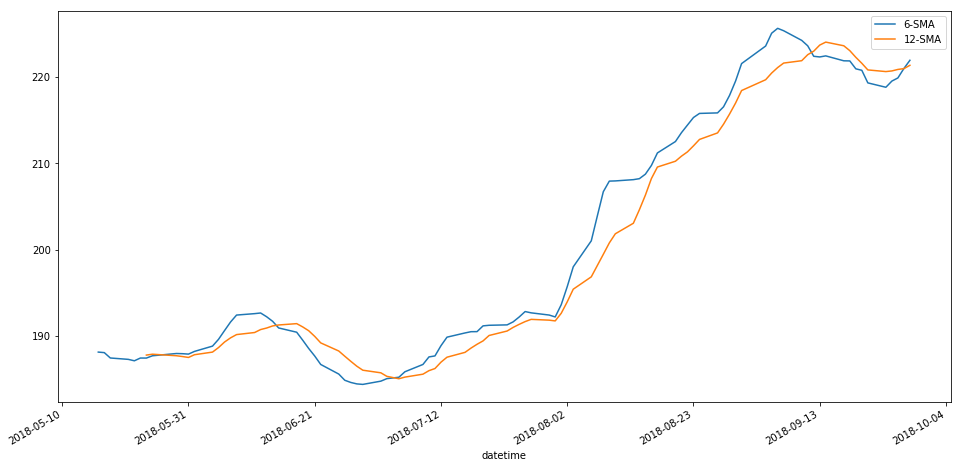

In [150]:
df.plot(figsize=(16,8))
"""
ax = plt.gca()
df.plot(kind='line', x='datetime', y='Close', ax=ax)
plt.show()
"""